<font size=6  color= 'blue' > <b>[LEPL1507] - PROJET P4</b> <br>
<br><br>
Airson Alexis<br>
Beniffou Ibrahim <br>
Henneaux Lucas <br>
Lemaire Antoine <br>
Smith Marielle <br>
Canon Théo<br>
<div style="text-align: right"> </div>

<br><br>
</font>


In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import os
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import random
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

c:\Users\Ibrahim\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#preprocessing of ppm dataset 
path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'
nbr_class = 62
resol = 30

DIR = path_training
counter = 0
for root, dirs, files in os.walk(DIR):
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print(counter)

batch_size_train = counter

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = (resol, resol),
batch_size = batch_size_train,class_mode = 'binary', color_mode='rgb')

DIR = path_testing
counter = 0
for root, dirs, files in os.walk(DIR):
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print(counter)

batch_size_test = counter

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(path_testing,
target_size = (resol, resol),batch_size = batch_size_test, class_mode = 'binary')


4575
Found 4575 images belonging to 62 classes.
2520
Found 2520 images belonging to 62 classes.


training_set = ensemble de 143 tuples
Chaque tuple représente 32 images (sauf le dernier, 31 images)

tuple[0] = features = tableau (32, 30, 30, 3)
tuple[1] = label = tableau (32)

plt.imshow(training_set[i][0][j]) affiche l'image n°j du paquet d'image n°i 

In [3]:
'''
On met toutes les données du Training Set dans un numpy array
'''

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#data augmentation
'''aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
aug.fit(X_train)'''

(4575, 30, 30, 3)
(4575,)
(2520, 30, 30, 3)
(2520,)


'aug = ImageDataGenerator(\n\trotation_range=10,\n\tzoom_range=0.15,\n\twidth_shift_range=0.1,\n\theight_shift_range=0.1,\n\tshear_range=0.15,\n\thorizontal_flip=False,\n\tvertical_flip=False,\n\tfill_mode="nearest")\naug.fit(X_train)'

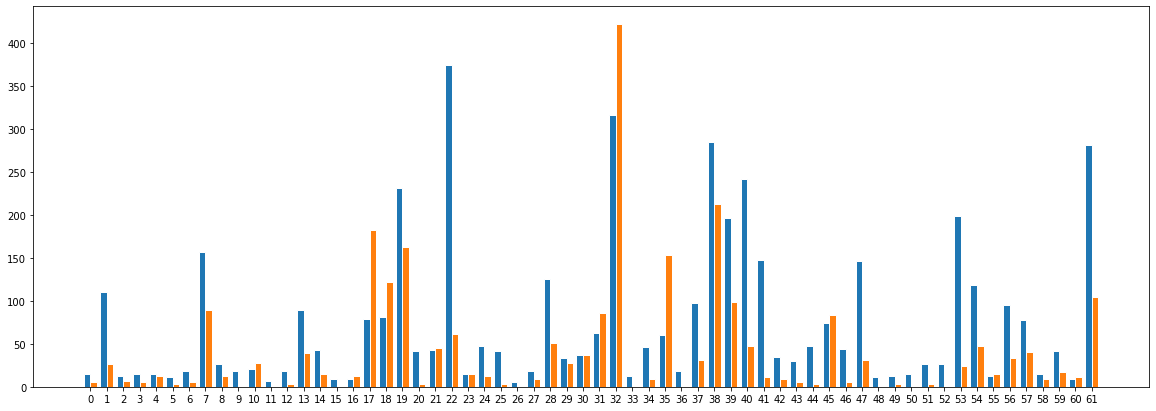

In [4]:
a = np.zeros(nbr_class, dtype=int)
b = np.zeros(nbr_class, dtype=int)
for i in range(nbr_class) :
    a[i] = int((y_train == i).sum())  # Nombre d'image de la classe n°i dans le Training set
    b[i] = int((y_test == i).sum())   # Nombre d'image de la classe n°i dans le Test set

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train, y_test], range = (0, nbr_class-1), bins=bins, edgecolor = 'white')
plt.xticks(np.arange(nbr_class))
plt.show()

In [ ]:

'''
Augmentation de données :

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(64, 64, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

augmented_image = data_augmentation(X_train[a:b])
augmented_image = data_augmentation(X_test[c:d])
==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris

idx = random.randint(a, b)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])

plt.subplot(1, 2, 2)
plt.imshow(augmented_image[idx])

'''

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(resol, resol, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

augmented_image_train = data_augmentation(X_train)
augmented_image_test = data_augmentation(X_test)

In [18]:
'''
1er méthode d'augmentation des données:
    Si le training set a moins d'éléments que le 3/4 du test set, on le rempli d'images augmentées
'''

memory = np.zeros((nbr_class, 2), dtype=int)
counter_train = 0
counter_test = 0
for i in range(nbr_class) :
    if a[i] < 3*b[i]/4 :  # On ajoute dans le Training Set
        if len(np.where(y_train == i)[0]) != 0 :
            memory[i][0] = np.abs(3*b[i]/4 - a[i])
            counter_train += int(np.abs(3*b[i]/4 - a[i]))

X_train_new = np.zeros((len(X_train) + counter_train, resol, resol, 3))
y_train_new = np.zeros(len(y_train) + counter_train)
X_train_new[:len(X_train)] = X_train
y_train_new[:len(y_train)] = y_train

X_test_new = np.zeros((len(X_test) + counter_test, resol, resol, 3))
y_test_new = np.zeros(len(y_test) + counter_test)
X_test_new[:len(X_test)] = X_test
y_test_new[:len(y_test)] = y_test

index_train = len(X_train)
index_test = len(X_test)
for i in range(nbr_class) :
    if memory[i][0] > 0 : # On ajoute dans le Training Set
        indices = np.where(y_train == i)
        augmented_image = tf.gather(augmented_image_train, indices=indices[0])
        for j in range(memory[i][0]) :
            idx = random.randint(0, len(indices[0])-1)
            X_train_new[index_train] = augmented_image[idx]
            y_train_new[index_train] = i
            index_train += 1

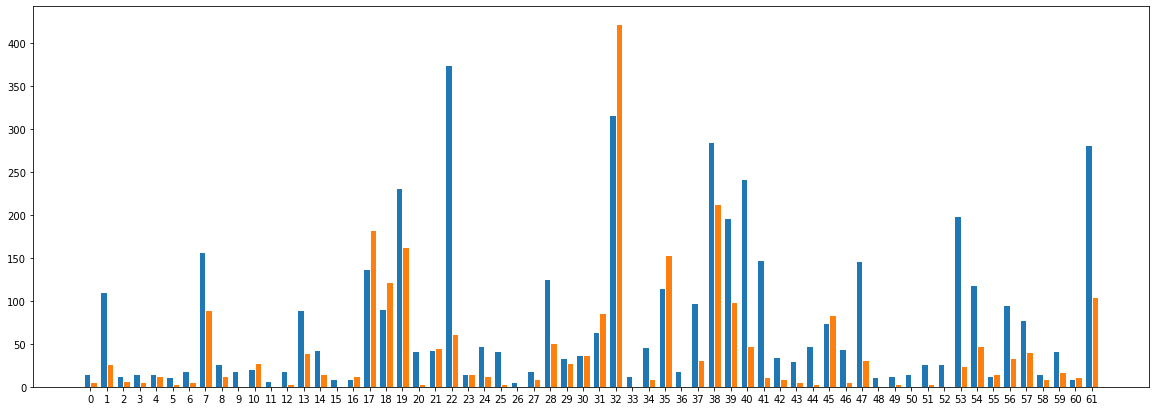

In [19]:
fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train_new, y_test_new], range = (0, nbr_class-1), bins=bins, edgecolor = 'white')
plt.xticks(np.arange(nbr_class))
plt.show()

In [7]:
'''
2e méthode d'augmentation des données:
    On augmente le training set de sorte à ce que toutes les classes soit représentées avec le même nombre, le max déjà présent
'''

memory = np.zeros(nbr_class, dtype=int)
lim = max(a)
counter = 0
for i in range(nbr_class) :
    memory[i] = lim - a[i]
    counter += lim - a[i]

X_train_new = np.zeros((len(X_train) + counter, resol, resol, 3))
y_train_new = np.zeros(len(y_train) + counter)
X_train_new[:len(X_train)] = X_train
y_train_new[:len(y_train)] = y_train

index = len(X_train)
for i in range(nbr_class) :
    indices = np.where(y_train == i)
    augmented_image = tf.gather(augmented_image_train, indices=indices[0])
    for j in range(memory[i]) :
        idx = random.randint(0, len(indices[0])-1)
        X_train_new[index] = augmented_image[idx]
        y_train_new[index] = i
        index += 1

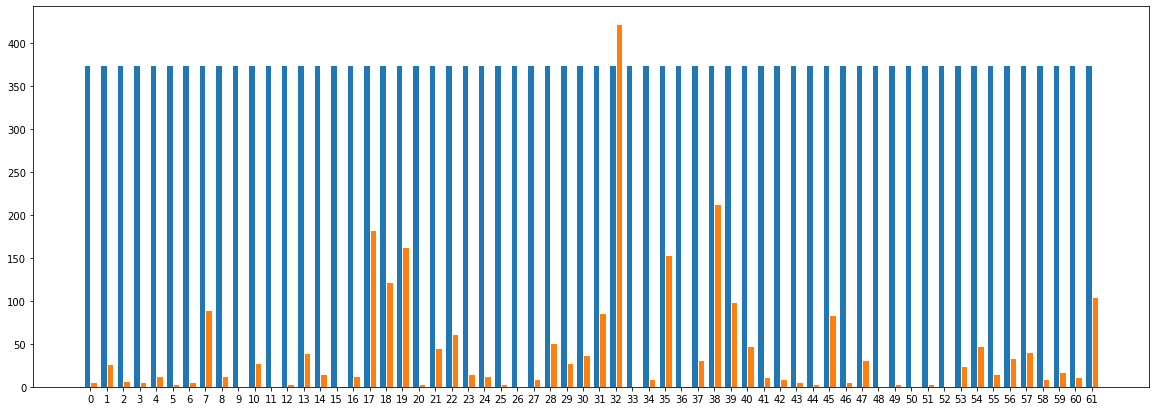

In [13]:
X_test_new = X_test
y_test_new = y_test

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train_new, y_test_new], range = (0, nbr_class-1), bins=bins, edgecolor = 'white')
plt.xticks(np.arange(nbr_class))
plt.show()

In [14]:
y_train_new_tc = to_categorical(y_train_new, nbr_class)
y_test_new_tc = to_categorical(y_test_new, nbr_class)

print(y_train_new_tc.shape)
print(y_test_new_tc.shape)

(23250, 62)
(2520, 62)


In [11]:
'''
On construit le modèle de prédiction sur base de la méthode CNN
'''

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_new.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [15]:
'''
On entraîne le modèle de prédiction
'''

eps = 15
#mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(X_train_new, y_train_new_tc, validation_data=(X_test_new, y_test_new_tc), epochs=eps)
#added aug.flow to (X_train, y_train) to do data augmentation


Epoch 1/15
727/727 [==============================] - 84s 114ms/step - loss: 2.4741 - accuracy: 0.3315 - val_loss: 0.6438 - val_accuracy: 0.7960
Epoch 2/15
727/727 [==============================] - 83s 115ms/step - loss: 0.9026 - accuracy: 0.7246 - val_loss: 0.4127 - val_accuracy: 0.8881
Epoch 3/15
727/727 [==============================] - 83s 114ms/step - loss: 0.5441 - accuracy: 0.8300 - val_loss: 0.3283 - val_accuracy: 0.9159
Epoch 4/15
727/727 [==============================] - 81s 112ms/step - loss: 0.4132 - accuracy: 0.8720 - val_loss: 0.3213 - val_accuracy: 0.9155
Epoch 5/15
727/727 [==============================] - 85s 116ms/step - loss: 0.3274 - accuracy: 0.8966 - val_loss: 0.3475 - val_accuracy: 0.9071
Epoch 6/15
727/727 [==============================] - 86s 119ms/step - loss: 0.2981 - accuracy: 0.9047 - val_loss: 0.2600 - val_accuracy: 0.9456
Epoch 7/15
727/727 [==============================] - 86s 118ms/step - loss: 0.2596 - accuracy: 0.9205 - val_loss: 0.3032 - val_ac

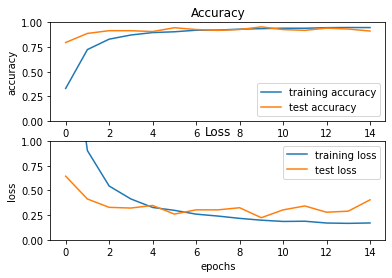

In [17]:
'''
On plot les résultats de performances
'''

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)

plt.show()

In [23]:
# evaluate the network
label_names = open("dict.csv").read().strip().split("\n")[0:]
label_names = [l.split(",")[1] for l in label_names]

print("[INFO] evaluating network...")
predictions = model.predict(X_test_new) 
print(classification_report(y_test_new_tc.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_names, labels=range(nbr_class-1)))


[INFO] evaluating network...
79/79 [==============================] - 1s 18ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       1.00      1.00      1.00         6
                         "bump"       0.87      1.00      0.93        27
                     "slippery"       1.00      1.00      1.00         7
                   "left_curve"       0.38      0.50      0.43         6
                  "right_curve"       1.00      0.75      0.86        12
                  "left_curves"       0.00      0.00      0.00         3
                 "right_curves"       0.40      0.33      0.36         6
                     "children"       0.90      1.00      0.95        90
                      "cyclist"       0.73      0.67      0.70        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       1.00      0.71      0.83        28
              "traffic_signals"       0.

A partir d'un ensemble de feature X_predict :

pred = model.predict_classes(X_predict)
print(accuracy_score(y_predict, pred))